In [1]:
%load_ext autoreload
%autoreload 2

In this notebook we ingest as an AXS Catalog the SDSS DR9 Quasar database,  and look for any ZTF observations for these objects.

### Connect to spark

In [2]:
import pyspark

spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()
   

See if everything is OK:

In [3]:
spark

### Load AXS catalog with ZTF 

In [4]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog(spark)
ztf_lc = axs_catalog.load("ztf_1am_lc") # ztf light curves .... 

### Ingest the SDSS S82 DR9 QSO catalog as AXS catalog

In [5]:
from astropy.table import Table
from pyspark.sql.types import *

File = 'DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
table = Table.read(File, format='ascii', names = colnames)
# make pandas df 
df = table.to_pandas()

# make spark df 
fields = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']

field_types = [IntegerType(),DoubleType(),DoubleType(),IntegerType(),
               DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               DoubleType()]

fields = [StructField(field_name, type_class, True) for field_name, 
          type_class in zip(fields, field_types)]
schema = StructType(fields)
sdf = spark.createDataFrame(df,schema=schema)

In [8]:
from axs import Constants
axs_catalog.save_axs_table(sdf,"sdss_dr9_qso_s82",  True, True, 500 ,Constants.ONE_AMIN)

Since the steps above have been done,  I can read in the results : 

In [9]:
qso = axs_catalog.load("sdss_dr9_qso_s82")

In [10]:
qso.head(1)

[Row(dbID=133470, ra=0.237056, dec=-1.069386, SDR5ID=40, M_i=-26.287, M_i_corr=-26.913, redshift=2.1065, mass_BH=0.0, Lbol=0.0, u=20.502, g=20.186, r=19.632, i=19.279, z=18.842, Au=0.213, zone=5335, dup=0)]

### Steps to crossmatch ZTF matchfiles (LC) to SDSS S82  DB9 QSO

S82 is a narrow strip in dec. Illustrate the extent :

Text(0,0.5,'dec')

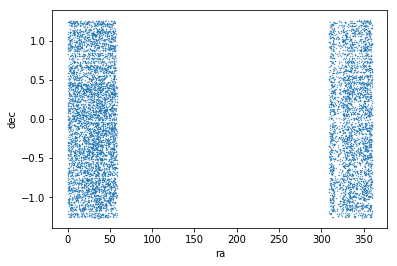

In [11]:
# Illustrate the extent of S82 : 
# it's a narrow strip in dec 
table = qso.select(['ra','dec']).limit(10000).toPandas()

%matplotlib inline
import matplotlib.pyplot as plt 
plt.scatter(table['ra'], table['dec'], s=0.1)
plt.xlabel('ra')
plt.ylabel('dec')

To speed up the process, we limit the range of ZTF to ra,dec covered by S82 : $\|{ \delta }\| < 1.3$. Also,  select ZTF light curves that have more than 1 good epoch : 

In [12]:
from pyspark.sql.functions import abs as sparkabs  # need to use the spark abs 

ztf_lc_select = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>1) & (sparkabs(ztf_lc['dec']) < 1.3) )

Show how many rows this selection includes... 

In [16]:
%%time 
ztf_lc_select.count()

CPU times: user 63.3 ms, sys: 24.4 ms, total: 87.7 ms
Wall time: 4min 51s


877407

Perform the crossmatch:

In [14]:
%%time
fname = "ztf_sdss_dr9_qso"
crossmatch = ztf_lc_select.crossmatch(qso, r=2*Constants.ONE_ASEC).\
    save_axs_table(fname)



CPU times: user 105 ms, sys: 24.4 ms, total: 129 ms
Wall time: 10min 17s


In [16]:
zq = axs_catalog.load("ztf_sdss_dr9_qso")

In [17]:
zq.head(1)

[]

The problem : no actual overlap ...

In [ ]:
t = ztf_lc_select.toPandas()

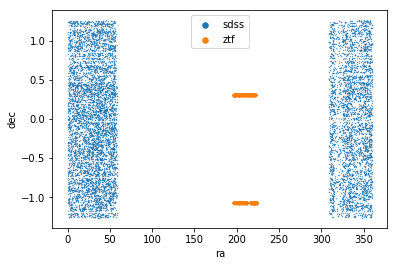

In [23]:
plt.scatter(table['ra'], table['dec'], s=0.1, label='sdss')
plt.scatter(t['ra'], t['dec'], s=0.01, label='ztf')
plt.xlabel('ra')
plt.ylabel('dec')
lgnd = plt.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]